In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import plotly.express as px
import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer


from sklearn.pipeline import Pipeline
import missingno as msno

In [2]:
# read file
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

In [3]:
#Dropping some columns which don't need for this analysis

train_df = train_df.drop(['address','latitude','longitude','id'], axis=1)
train_df.head()

,province,district,subdistrict,property_type,total_units,bedrooms,baths,floor_area,floor_level,land_area,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price
0,Bangkok,Watthana,Phra Khanong Nuea,Condo,273.0,2.0,2.0,66,10.0,NaN,2,"[[E7 Ekkamai BTS, 270], [E6 Thong Lo BTS, 800]]",NaN,16.0,20,2011,June,"[Car Park, Community Garden, CCTV, Fitness cor...",8500000
1,Bangkok,Watthana,Khlong Toei Nuea,Condo,74.0,1.0,1.0,49,8.0,NaN,3,"[[BL22 Sukhumvit MRT, 720], [BL21 Phetchaburi ...",NaN,11.0,20,2012,September,"[CCTV, Fitness corner, 24 hours security, Swim...",5900000
2,Bangkok,Khlong Toei,Khlong Tan,Condo,940.0,1.0,1.0,34,4.0,NaN,2,"[[E5 Phrom Phong BTS, 650], [BL23 Queen Siriki...",NaN,20.0,20,2017,January,"[Car Park, Clubhouse, Community Garden, CCTV, ...",6290000
3,Nonthaburi,Bang Kruai,Bang Khun Kong,Detached House,NaN,3.0,3.0,170,NaN,248.0,0,None,NaN,2.0,4,0,None,"[Covered car park, Playground, 24 hours securi...",8900000
4,Nonthaburi,Mueang Nonthaburi,Bang Phai,Townhouse,NaN,3.0,2.0,120,NaN,72.0,1,"[[PP09 Yaek Nonthaburi 1 MRT, 10]]",NaN,6.0,15,0,None,"[Covered car park, 24 hours security]",2390000


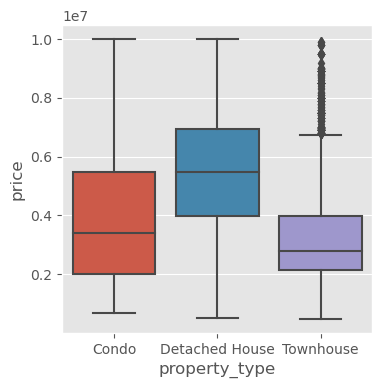

In [4]:
# seeing distribution of price by proerty_type

plt.figure(figsize = (4, 4))
sns.boxplot(data=train_df,x='property_type', y='price');

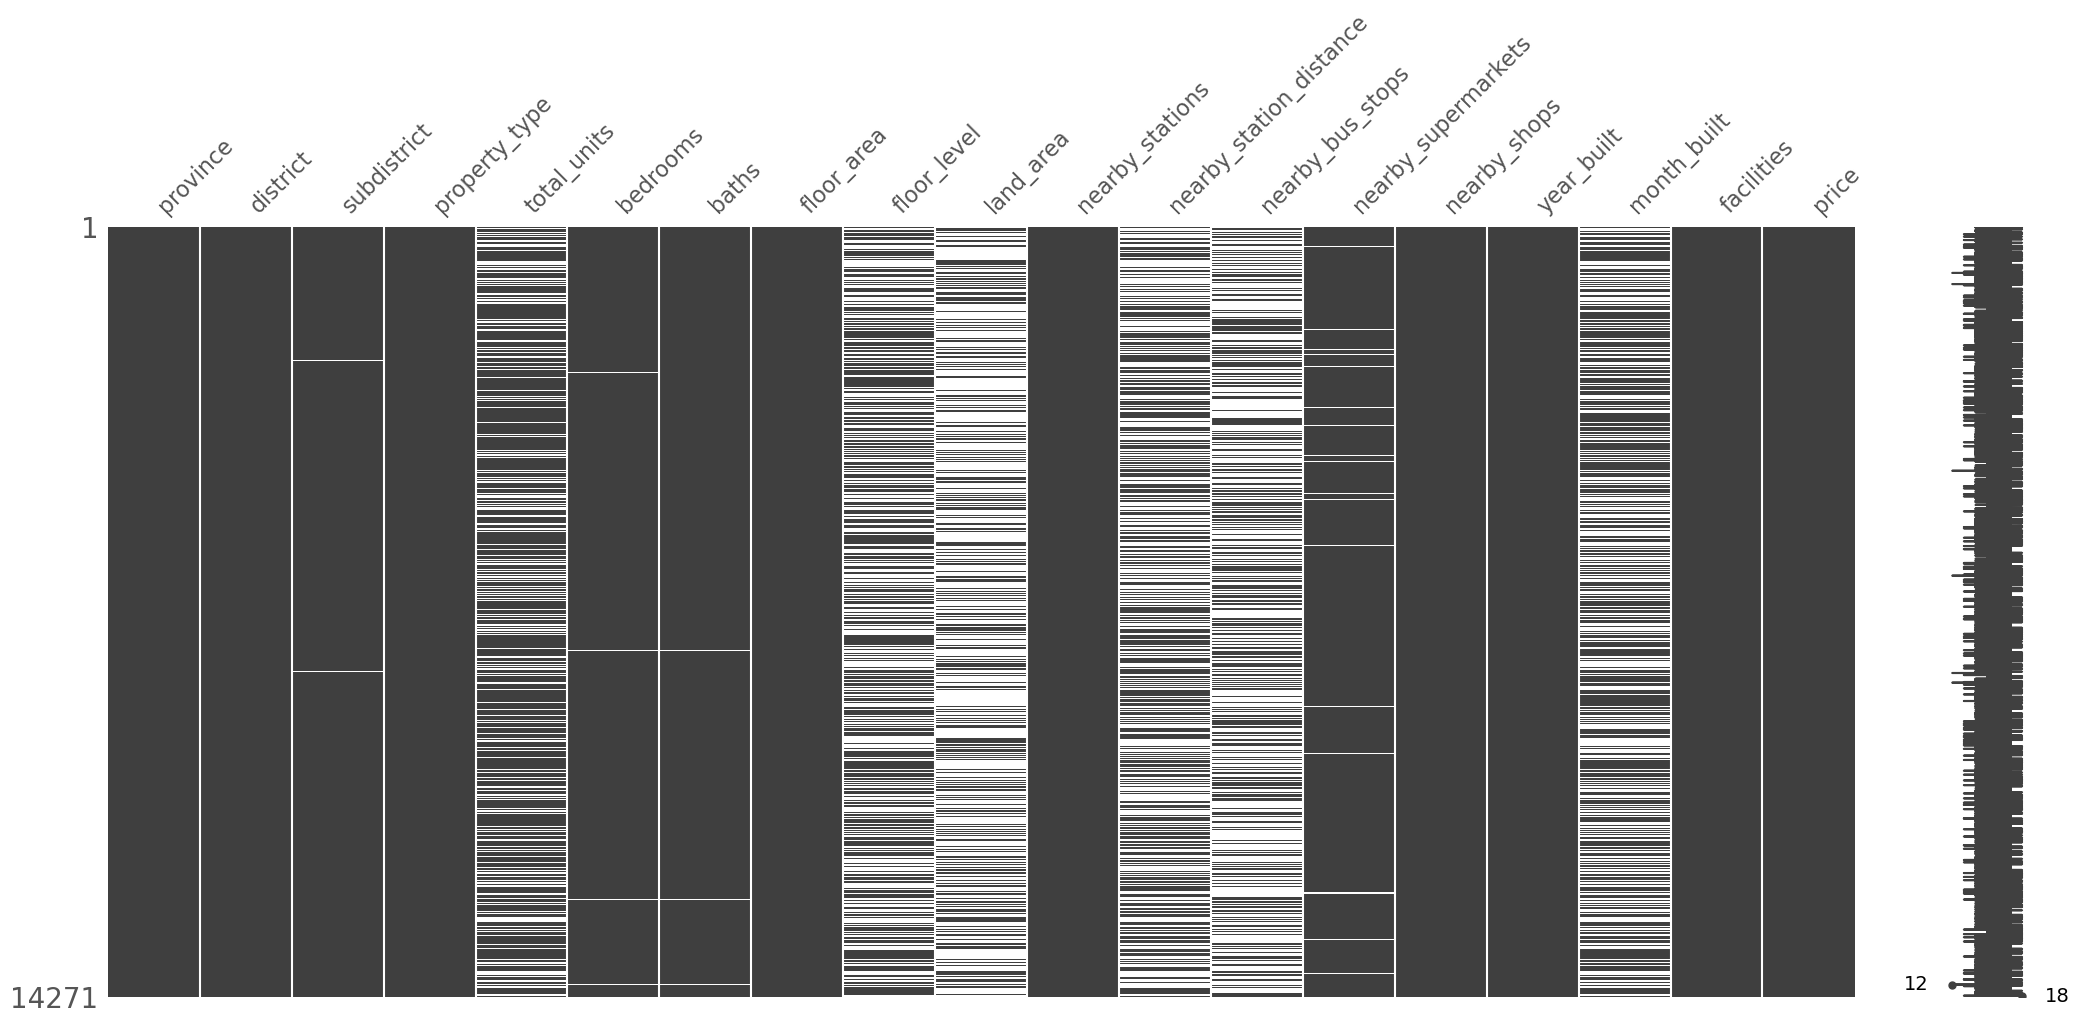

In [5]:
# Seeing overall missing value
msno.matrix(train_df);

In [6]:
# Dropping null in a specific columns

train_df.dropna(subset=['bedrooms', 'baths','subdistrict'],inplace=True)
train_df.shape

(14215, 19)

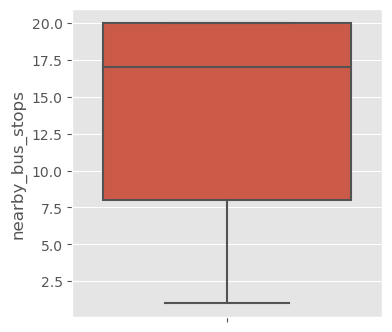

In [7]:
# nearby_bus_stops boxplot

plt.figure(figsize = (4, 4))
sns.boxplot(data=train_df,y='nearby_bus_stops');

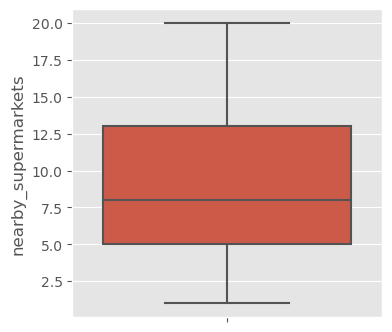

In [8]:
# nearby_supermarkets boxplot

plt.figure(figsize = (4, 4))
sns.boxplot(data=train_df,y='nearby_supermarkets');

In [9]:
# Based on the boxplots, showing the minimum values of 'nearby_bus_stop' and 'nearby_supermarkets' higher than zero. 
# I assume the null could be replaced by zeros.

train_df['nearby_bus_stops'] = train_df['nearby_bus_stops'].fillna(0)
train_df['nearby_supermarkets'] = train_df['nearby_supermarkets'].fillna(0)


In [10]:
#New column added : extract the closest station name and the distance to the closest station

def closest_station(station_list, return_value='station_name'):
    if type(station_list) != list:
        if return_value == 'station_name':
            return "NO STATION"
        elif return_value == 'station_distance':
            return 2000
    else:
        if return_value == 'station_name':
            return station_list[0][0]
        elif return_value == 'station_distance':
            return station_list[0][1]

train_df['closest_station_name'] = train_df.nearby_station_distance.apply(lambda x: closest_station(x, 'station_name'))
train_df['closest_station_distance'] = train_df.nearby_station_distance.apply(lambda x: closest_station(x, 'station_distance'))

In [11]:
#New column added :count the MRT from the list of nearby_station_distance column

def get_train_count(station_list, train_name='MRT'):
    if type(station_list) != list:
        return 0
    else:
        count = 0
        for pair in station_list:
            if train_name in pair[0]:
                count += 1
        return count

train_df['mrt_count'] = train_df['nearby_station_distance'].apply(lambda x: get_train_count(x, 'MRT'))

In [12]:
#New column added :count the BTS from the list of nearby_station_distance column

def get_train_count(station_list, train_name='BTS'):
    if type(station_list) != list:
        return 0
    else:
        count = 0
        for pair in station_list:
            if train_name in pair[0]:
                count += 1
        return count

train_df['bts_count'] = train_df['nearby_station_distance'].apply(lambda x: get_train_count(x, 'BTS'))

In [13]:
#New column added :count the SRT from the list of nearby_station_distance column

def get_train_count(station_list, train_name='SRT'):
    if type(station_list) != list:
        return 0
    else:
        count = 0
        for pair in station_list:
            if train_name in pair[0]:
                count += 1
        return count

train_df['srt_count'] = train_df['nearby_station_distance'].apply(lambda x: get_train_count(x, 'SRT'))

In [14]:
#New column added : count the SRT from the list of Airport Link column

def get_train_count(station_list, train_name='Airport Link'):
    if type(station_list) != list:
        return 0
    else:
        count = 0
        for pair in station_list:
            if train_name in pair[0]:
                count += 1
        return count

train_df['arl_count'] = train_df['nearby_station_distance'].apply(lambda x: get_train_count(x, 'Airport Link'))

In [15]:
# drop the 'nearby_station_distance' after extraction

train_df = train_df.drop(['nearby_station_distance'], axis=1)

## Condo

In [16]:
# split the DataFrame filtered 'Condo' only

train_df_condo = train_df[train_df['property_type']=='Condo']
train_df_condo.head()

,province,district,subdistrict,property_type,total_units,bedrooms,baths,floor_area,floor_level,land_area,...,year_built,month_built,facilities,price,closest_station_name,closest_station_distance,mrt_count,bts_count,srt_count,arl_count
0,Bangkok,Watthana,Phra Khanong Nuea,Condo,273.0,2.0,2.0,66,10.0,NaN,...,2011,June,"[Car Park, Community Garden, CCTV, Fitness cor...",8500000,E7 Ekkamai BTS,270,0,2,0,0
1,Bangkok,Watthana,Khlong Toei Nuea,Condo,74.0,1.0,1.0,49,8.0,NaN,...,2012,September,"[CCTV, Fitness corner, 24 hours security, Swim...",5900000,BL22 Sukhumvit MRT,720,2,1,0,0
2,Bangkok,Khlong Toei,Khlong Tan,Condo,940.0,1.0,1.0,34,4.0,NaN,...,2017,January,"[Car Park, Clubhouse, Community Garden, CCTV, ...",6290000,E5 Phrom Phong BTS,650,1,1,0,0
5,Bangkok,Bang Rak,Si Phraya,Condo,211.0,1.0,1.0,54,6.0,NaN,...,2014,December,"[CCTV, Fitness corner, 24 hours security, Sky ...",8549000,G2 Charoen Nakhon BTS,820,0,3,0,0
6,Nonthaburi,Pak Kret,Pak Kret,Condo,851.0,2.0,1.0,59,4.0,NaN,...,2014,July,"[Car Park, Clubhouse, Community Garden, CCTV, ...",1950000,NO STATION,2000,0,0,0,0


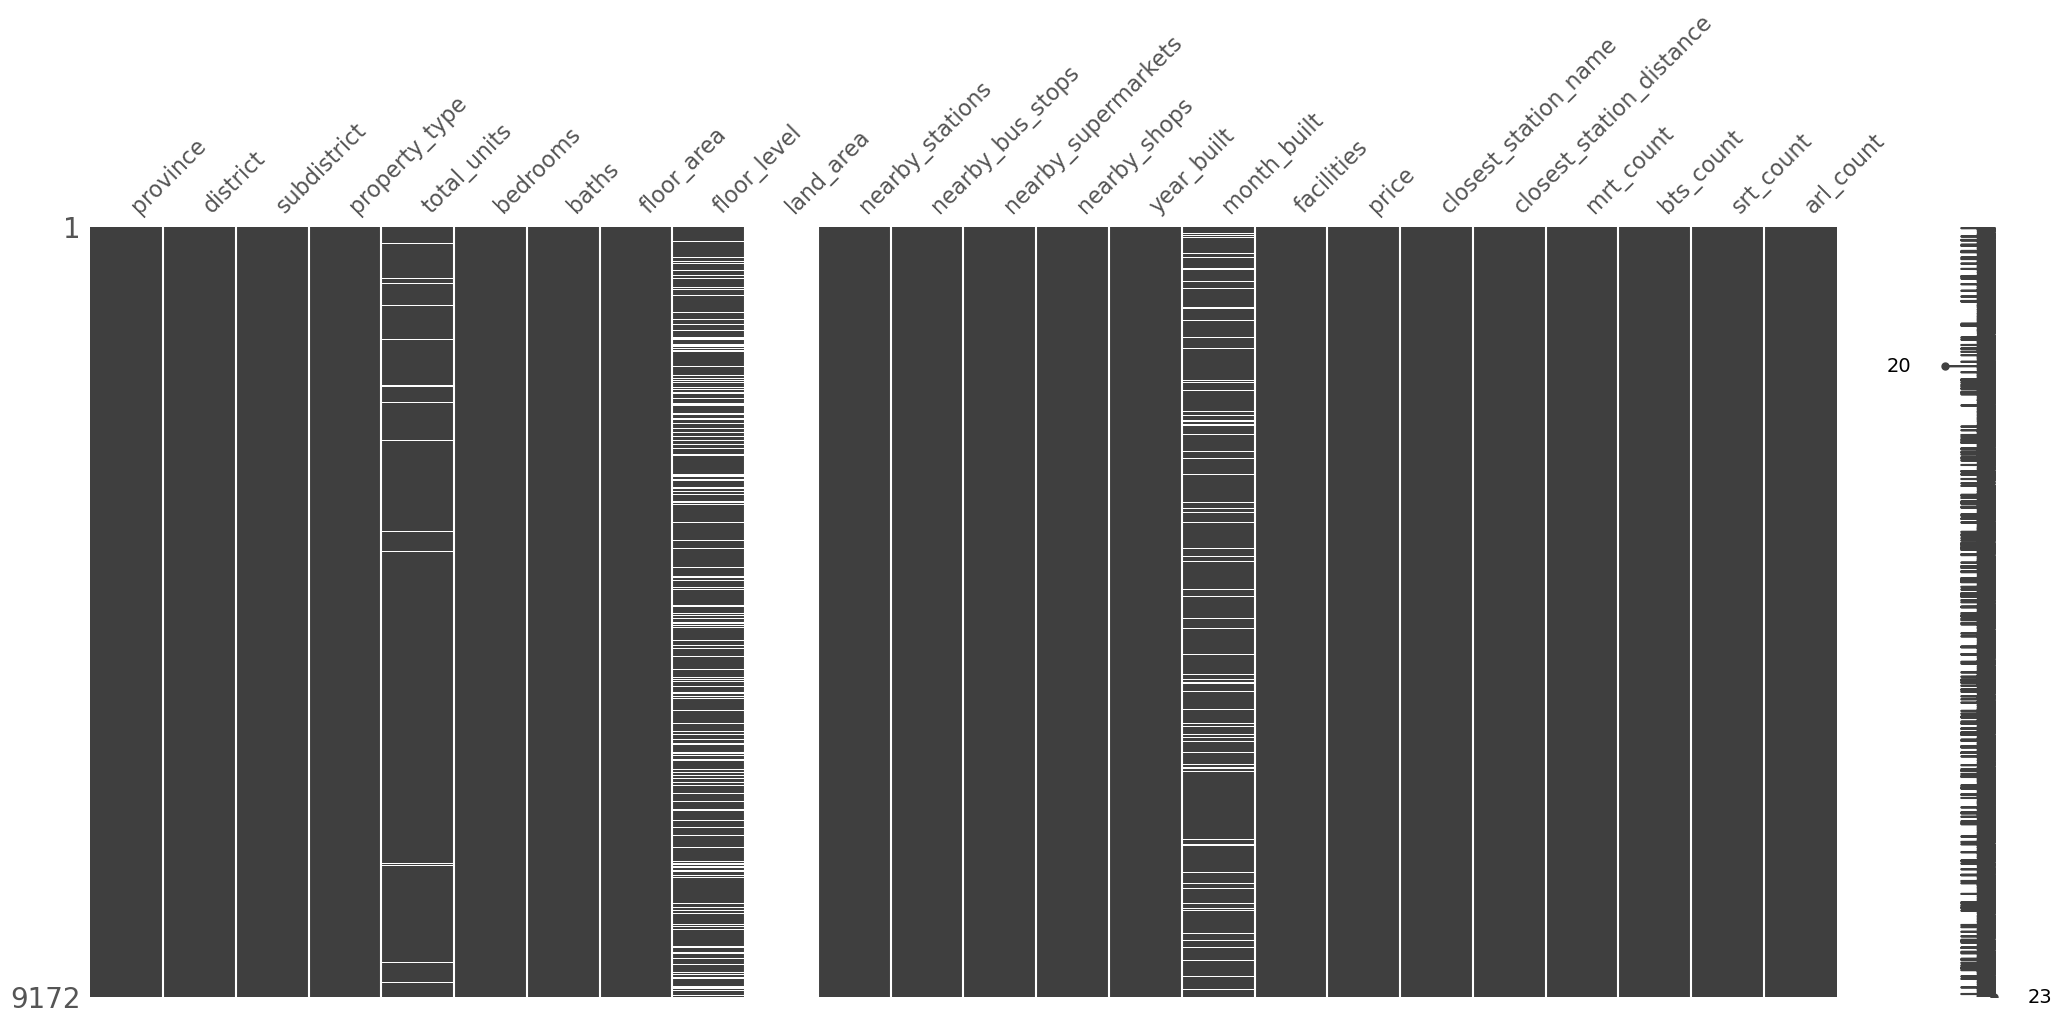

In [17]:
# seeing the missing value of Condo DataFrame
msno.matrix(train_df_condo);

In [18]:
#Drop land_area columns as all blank

train_df_condo = train_df_condo.drop(['land_area'], axis=1)
train_df_condo.head()

,province,district,subdistrict,property_type,total_units,bedrooms,baths,floor_area,floor_level,nearby_stations,...,year_built,month_built,facilities,price,closest_station_name,closest_station_distance,mrt_count,bts_count,srt_count,arl_count
0,Bangkok,Watthana,Phra Khanong Nuea,Condo,273.0,2.0,2.0,66,10.0,2,...,2011,June,"[Car Park, Community Garden, CCTV, Fitness cor...",8500000,E7 Ekkamai BTS,270,0,2,0,0
1,Bangkok,Watthana,Khlong Toei Nuea,Condo,74.0,1.0,1.0,49,8.0,3,...,2012,September,"[CCTV, Fitness corner, 24 hours security, Swim...",5900000,BL22 Sukhumvit MRT,720,2,1,0,0
2,Bangkok,Khlong Toei,Khlong Tan,Condo,940.0,1.0,1.0,34,4.0,2,...,2017,January,"[Car Park, Clubhouse, Community Garden, CCTV, ...",6290000,E5 Phrom Phong BTS,650,1,1,0,0
5,Bangkok,Bang Rak,Si Phraya,Condo,211.0,1.0,1.0,54,6.0,3,...,2014,December,"[CCTV, Fitness corner, 24 hours security, Sky ...",8549000,G2 Charoen Nakhon BTS,820,0,3,0,0
6,Nonthaburi,Pak Kret,Pak Kret,Condo,851.0,2.0,1.0,59,4.0,0,...,2014,July,"[Car Park, Clubhouse, Community Garden, CCTV, ...",1950000,NO STATION,2000,0,0,0,0


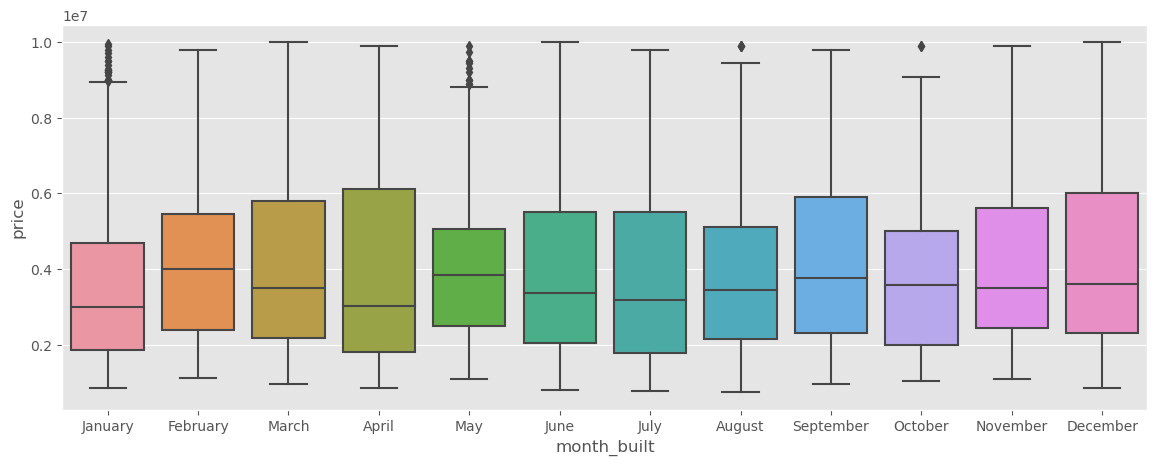

In [19]:
#Seeing the condo price distribution by month_built

plt.figure(figsize = (14, 5))
order = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.boxplot(y="price", x='month_built', data=train_df_condo, order=order);

In [20]:
# drop the month_built column as condo price distribution in each month_built not different

train_df_condo = train_df_condo.drop(['month_built'], axis=1)


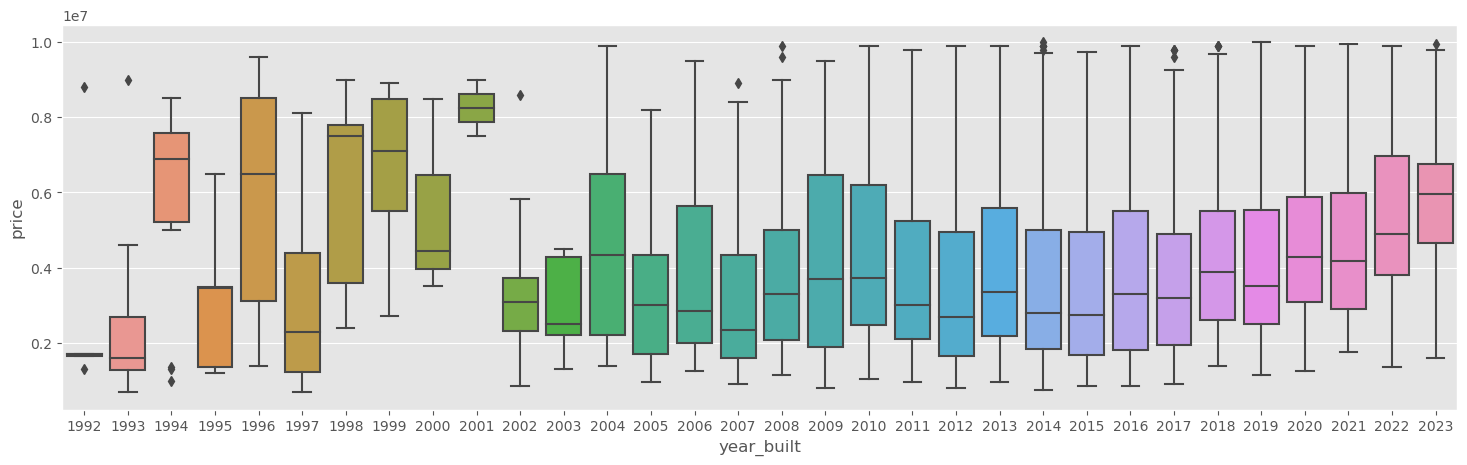

In [21]:
#Seeing the condo price distribution by year_built

plt.figure(figsize = (18, 5))
sns.boxplot(data=train_df_condo,x='year_built', y='price');

In [22]:
# Drop some observation whose year_built in the below value list as their price not in the same trend of the majority data 

values = [1994,1996,1998,1999,2000,2001]

train_df_condo = train_df_condo[train_df_condo.year_built.isin(values) == False]


In [23]:
# impute the missing value in total_units column by the median of price value which group by subdistrict

train_df_condo.total_units = train_df_condo.groupby('subdistrict')['total_units'].apply(lambda x: x.fillna(x.median()))
train_df_condo.total_units = train_df_condo.total_units.fillna(train_df_condo.total_units.median())

C:\Users\yodchan\AppData\Local\Temp\ipykernel_18060\3451949823.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_df_condo.total_units = train_df_condo.groupby('subdistrict')['total_units'].apply(lambda x: x.fillna(x.median()))


In [24]:
# impute the missing value in floor_level column by the median of price value which group by subdistrict

train_df_condo.floor_level = train_df_condo.groupby('subdistrict')['floor_level'].apply(lambda x: x.fillna(x.median()))
train_df_condo.floor_level = train_df_condo.floor_level.fillna(train_df_condo.floor_level.median())

C:\Users\yodchan\AppData\Local\Temp\ipykernel_18060\1942132085.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_df_condo.floor_level = train_df_condo.groupby('subdistrict')['floor_level'].apply(lambda x: x.fillna(x.median()))


In [25]:
#Drop the subdistrict column after groupping

train_df_condo = train_df_condo.drop(['subdistrict'], axis=1)

In [26]:
#Seeing the correlation of features with price
pd.DataFrame(train_df_condo.corr(numeric_only=True)['price'].sort_values(ascending = False))

,price
price,1.000000
floor_area,0.538680
nearby_shops,0.459276
nearby_stations,0.429618
bts_count,0.390942
nearby_supermarkets,0.390459
bedrooms,0.348176
baths,0.335953
floor_level,0.247946
arl_count,0.174884


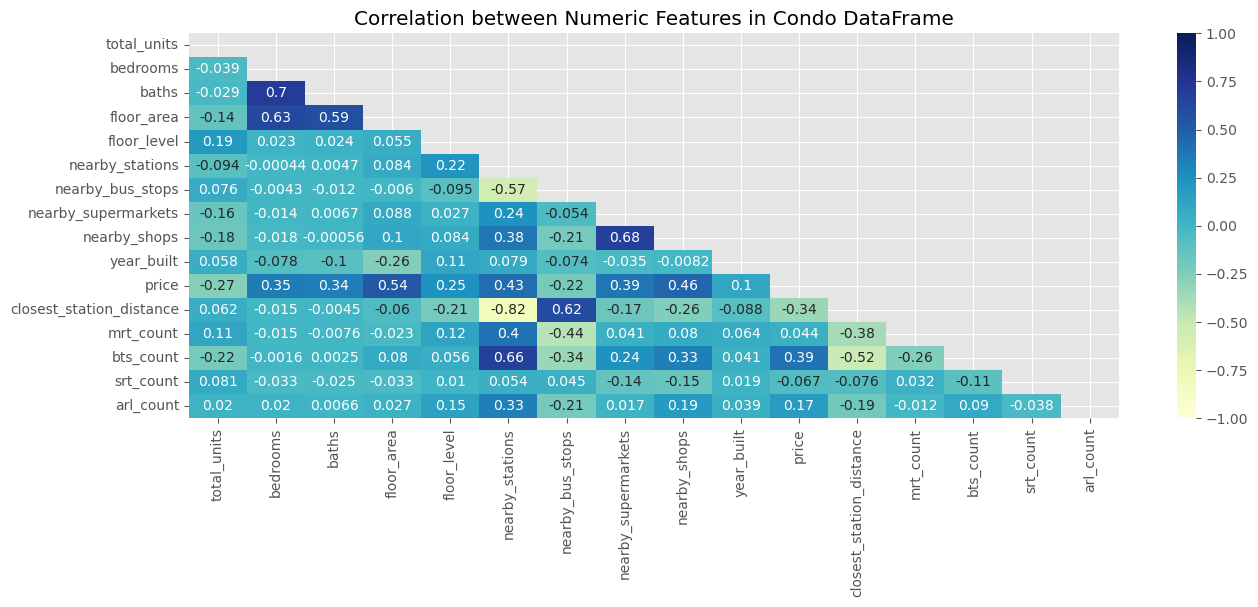

In [27]:
# Correlation plot

plt.figure(figsize = (15, 5))

corr = pd.DataFrame(train_df_condo.corr(numeric_only=True))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='YlGnBu', vmin=-1, vmax=1, annot=True, mask=mask);
plt.title("Correlation between Numeric Features in Condo DataFrame");

In [28]:
# count the facilities in each observation

from collections import Counter 

facility_counter = Counter()
for i in train_df_condo.facilities:
    facility_counter.update(i)

facility_counter.most_common()[:30]

[('24 hours security', 8899),
 ('CCTV', 8709),
 ('Swimming pool', 8382),
 ('Fitness corner', 8024),
 ('Car Park', 5047),
 ('Covered car park', 5010),
 ('Lift lobby', 3147),
 ('Gymnasium room', 2609),
 ('Library', 2232),
 ('Community Garden', 2126),
 ('Mini-Mart', 1964),
 ('Sauna', 1910),
 ('Sky Lounge', 1318),
 ('Steam bath', 1270),
 ('Clubhouse', 1254),
 ('Playground', 1210),
 ('Wading pool', 1179),
 ('Lounge', 1019),
 ('Launderette', 935),
 ('Function room', 864),
 ('Open car park', 816),
 ('Pavillion', 765),
 ('Jacuzzi', 690),
 ('Club', 676),
 ('Multi-purpose hall', 591),
 ('BBQ pits', 513),
 ('Game room', 505),
 ('Eateries', 470),
 ("Children's Playground", 407),
 ('Spa pool', 397)]

In [29]:
# extact the unique facility and create condition if an observation have a kind of facility , then input 1 to the column.

for col in facility_counter.keys():
    train_df_condo[col] = train_df_condo['facilities'].apply(lambda x: 1 if col in x else 0)

In [30]:
# dummify the string columns

train_df_condo = pd.get_dummies(data=train_df_condo, columns = ['closest_station_name','district'], drop_first = True)
train_df_condo.head()

,province,property_type,total_units,bedrooms,baths,floor_area,floor_level,nearby_stations,nearby_bus_stops,nearby_supermarkets,...,district_Ratchathewi,district_Sai Mai,district_Sathon,district_Suan Luang,district_Taling Chan,district_Thon Buri,district_Thung Khru,district_Wang Thonglang,district_Watthana,district_Yan Nawa
0,Bangkok,Condo,273.0,2.0,2.0,66,10.0,2,0.0,16.0,...,0,0,0,0,0,0,0,0,1,0
1,Bangkok,Condo,74.0,1.0,1.0,49,8.0,3,0.0,11.0,...,0,0,0,0,0,0,0,0,1,0
2,Bangkok,Condo,940.0,1.0,1.0,34,4.0,2,0.0,20.0,...,0,0,0,0,0,0,0,0,0,0
5,Bangkok,Condo,211.0,1.0,1.0,54,6.0,3,0.0,14.0,...,0,0,0,0,0,0,0,0,0,0
6,Nonthaburi,Condo,851.0,2.0,1.0,59,4.0,0,20.0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#drop columns *property_type contains 'Condo' only so drop it

train_df_condo = train_df_condo.drop(['property_type','facilities'], axis=1)
train_df_condo.head()

,province,total_units,bedrooms,baths,floor_area,floor_level,nearby_stations,nearby_bus_stops,nearby_supermarkets,nearby_shops,...,district_Ratchathewi,district_Sai Mai,district_Sathon,district_Suan Luang,district_Taling Chan,district_Thon Buri,district_Thung Khru,district_Wang Thonglang,district_Watthana,district_Yan Nawa
0,Bangkok,273.0,2.0,2.0,66,10.0,2,0.0,16.0,20,...,0,0,0,0,0,0,0,0,1,0
1,Bangkok,74.0,1.0,1.0,49,8.0,3,0.0,11.0,20,...,0,0,0,0,0,0,0,0,1,0
2,Bangkok,940.0,1.0,1.0,34,4.0,2,0.0,20.0,20,...,0,0,0,0,0,0,0,0,0,0
5,Bangkok,211.0,1.0,1.0,54,6.0,3,0.0,14.0,20,...,0,0,0,0,0,0,0,0,0,0
6,Nonthaburi,851.0,2.0,1.0,59,4.0,0,20.0,2.0,9,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# seperate features(factors) and Target Variable

train_df_condo._get_numeric_data().columns

features = [col for col in train_df_condo._get_numeric_data().columns if col !='price']
X = train_df_condo[features]
y = train_df_condo['price']


#Split training set and test set with default test size = 0.25

X_train_condo, X_test_condo, y_train_condo, y_test_condo = train_test_split(X,y,random_state=42)


# standardzie all the numberic features

ss = StandardScaler()
ss.fit(X_train_condo)
X_train_condo_scaled = ss.transform(X_train_condo)
X_test_condo_scaled = ss.transform(X_test_condo)


In [33]:
# Define the model to use

lasso = LassoCV(n_alphas=100)

In [34]:
#Train the model on traing set

lasso.fit(X_train_condo_scaled,y_train_condo)

LassoCV()

In [35]:
# using cross validation to find best alpha

lasso_scores = cross_val_score(lasso,X_train_condo_scaled,y_train_condo, cv=5)
lasso_scores.mean()

0.8181966431785282

In [36]:
#Best alpha
lasso.alpha_

1629.0141494466347

In [37]:
#R-Square Score on Training set

lasso.score(X_train_condo_scaled,y_train_condo)

0.836603924131606

In [38]:
#R-Square Score on Test set
lasso.score(X_test_condo_scaled,y_test_condo)

0.7672291655315807

In [39]:
#Seeing the Coefficient by columns

output_condo = pd.DataFrame(pd.Series(lasso.coef_,index=features).sort_values(ascending=False), columns = ['Coefficient(LassoCV)'])
output_condo

,Coefficient(LassoCV)
floor_area,933445.702345
closest_station_name_NO STATION,645681.134843
district_Watthana,524577.149013
year_built,401975.753450
district_Khlong Toei,342879.909802
...,...
total_units,-107237.369214
closest_station_name_PP03 Sam Yaek Bang Yai MRT,-135356.272369
closest_station_name_PP13 Yaek Tiwanon MRT,-147282.383687
closest_station_name_PP10 Bang Krasor MRT,-161931.682796


In [40]:
# Top5 coef
output_condo.head(5)

,Coefficient(LassoCV)
floor_area,933445.702345
closest_station_name_NO STATION,645681.134843
district_Watthana,524577.149013
year_built,401975.753450
district_Khlong Toei,342879.909802


In [41]:
# Bottom5 coef
output_condo.tail(5)

,Coefficient(LassoCV)
total_units,-107237.369214
closest_station_name_PP03 Sam Yaek Bang Yai MRT,-135356.272369
closest_station_name_PP13 Yaek Tiwanon MRT,-147282.383687
closest_station_name_PP10 Bang Krasor MRT,-161931.682796
closest_station_distance,-876662.493607


In [42]:
# features that Lasso eliminate

output_condo[output_condo['Coefficient(LassoCV)']==0]

,Coefficient(LassoCV)
closest_station_name_N11 Ratchayothin BTS,-0.0
closest_station_name_BL38 Lak Song MRT,-0.0
closest_station_name_E14 Bearing BTS,-0.0
closest_station_name_G1/S7 Krung Thon Buri BTS,-0.0
closest_station_name_BL10/PP16 Tao Poon MRT,-0.0
Mini golf range,0.0
Badminton hall,0.0
Eateries,0.0
closest_station_name_A3 Ban Thap Chang Airport Link,-0.0
closest_station_name_A6 Makkasan Airport Link,0.0


In [43]:
# RMSE on Training Set

pred_train = lasso.predict(X_train_condo_scaled)

np.sqrt(mean_squared_error(y_train_condo,pred_train))

882666.255305092

In [44]:
# RMSE on Test Set

pred = lasso.predict(X_test_condo_scaled)

np.sqrt(mean_squared_error(y_test_condo,pred))

1056890.3564642114

## Non Condo

In [45]:
train_df_non_condo = train_df[train_df['property_type']!='Condo']
train_df_non_condo.head()

,province,district,subdistrict,property_type,total_units,bedrooms,baths,floor_area,floor_level,land_area,...,year_built,month_built,facilities,price,closest_station_name,closest_station_distance,mrt_count,bts_count,srt_count,arl_count
3,Nonthaburi,Bang Kruai,Bang Khun Kong,Detached House,NaN,3.0,3.0,170,NaN,248.0,...,0,None,"[Covered car park, Playground, 24 hours securi...",8900000,NO STATION,2000,0,0,0,0
4,Nonthaburi,Mueang Nonthaburi,Bang Phai,Townhouse,NaN,3.0,2.0,120,NaN,72.0,...,0,None,"[Covered car park, 24 hours security]",2390000,PP09 Yaek Nonthaburi 1 MRT,10,1,0,0,0
7,Bangkok,Sai Mai,Sai Mai,Townhouse,NaN,2.0,2.0,105,NaN,72.0,...,0,None,[Covered car park],1990000,NO STATION,2000,0,0,0,0
11,Samut Prakan,Mueang Samut Prakan,Thepharak,Townhouse,NaN,3.0,3.0,108,NaN,132.0,...,0,None,[24 hours security],3230000,NO STATION,2000,0,0,0,0
12,Bangkok,Prawet,Dok Mai,Townhouse,NaN,4.0,2.0,117,NaN,76.0,...,0,None,[],3600000,NO STATION,2000,0,0,0,0


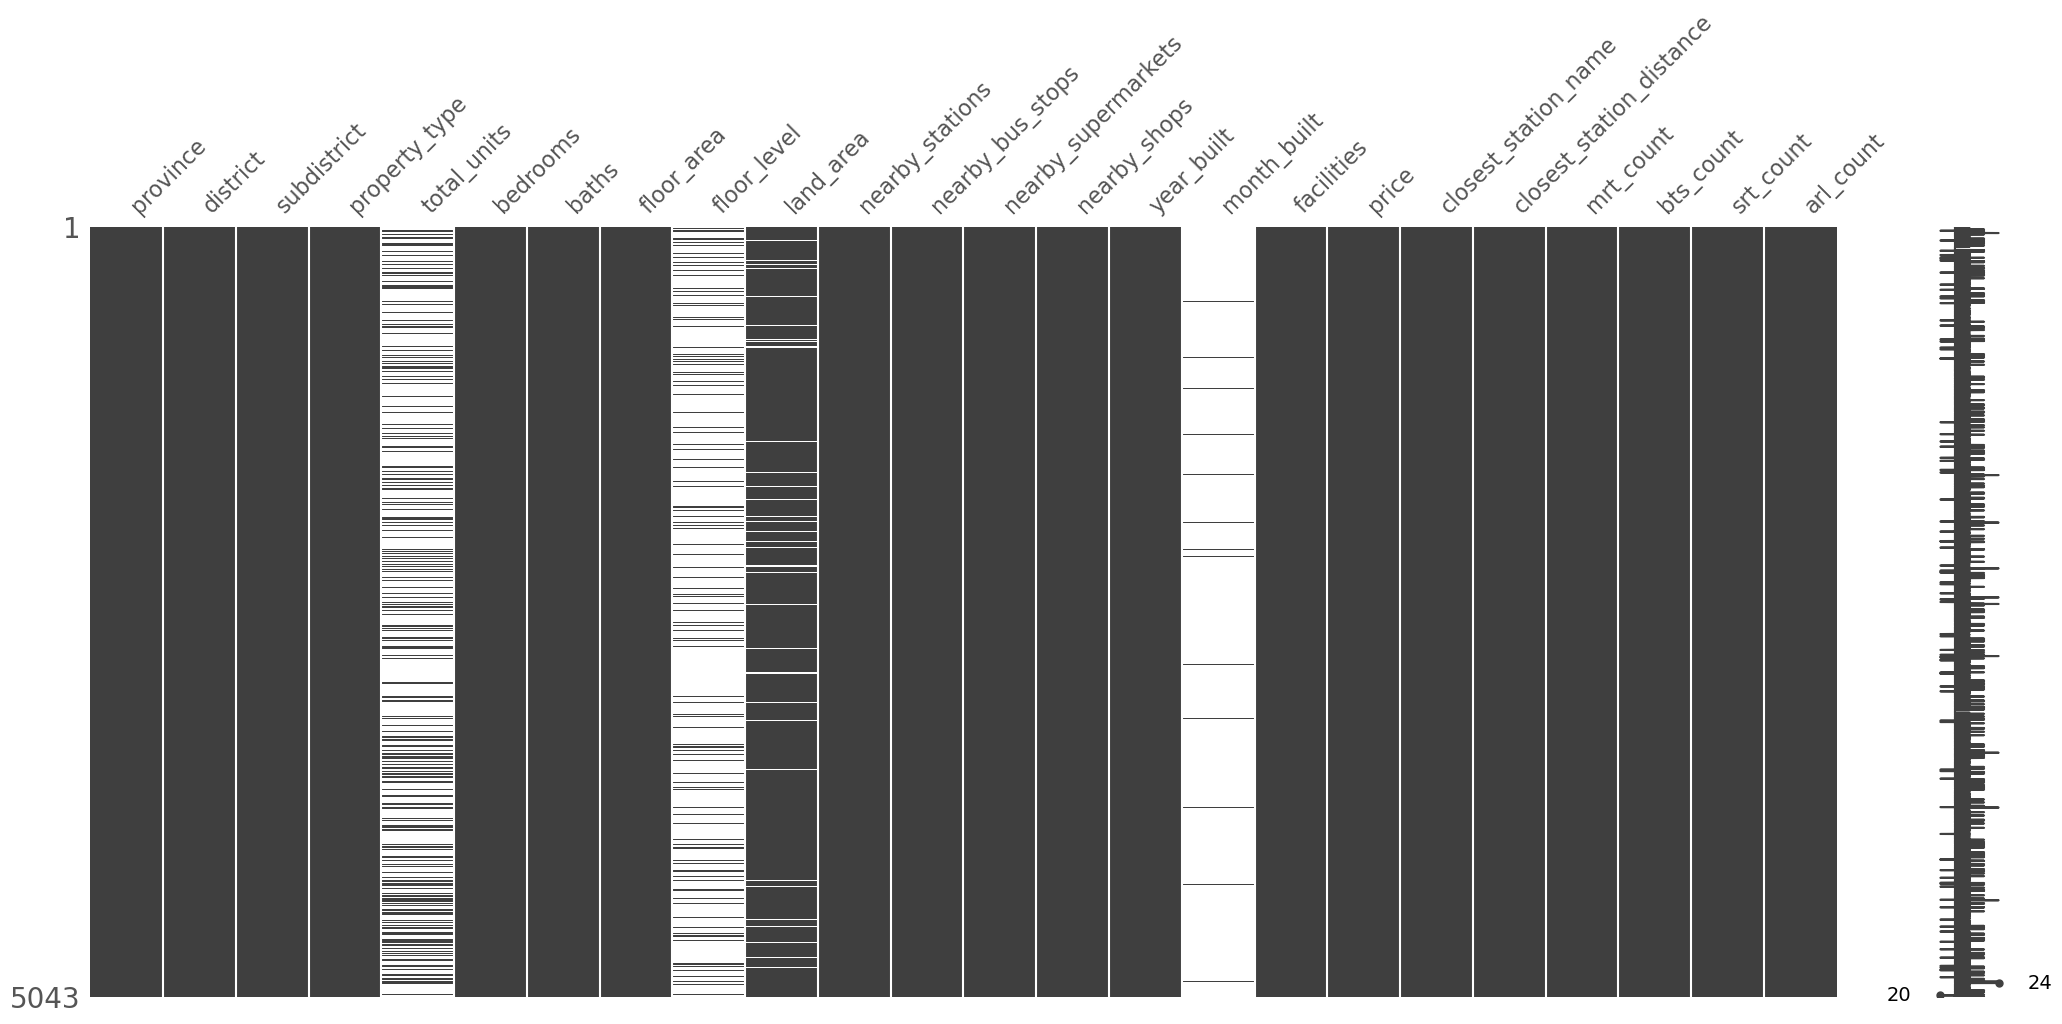

In [46]:
msno.matrix(train_df_non_condo);

In [47]:
train_df_non_condo = train_df_non_condo.drop(['month_built','year_built','floor_level'], axis=1)
train_df_non_condo.head()

,province,district,subdistrict,property_type,total_units,bedrooms,baths,floor_area,land_area,nearby_stations,...,nearby_supermarkets,nearby_shops,facilities,price,closest_station_name,closest_station_distance,mrt_count,bts_count,srt_count,arl_count
3,Nonthaburi,Bang Kruai,Bang Khun Kong,Detached House,NaN,3.0,3.0,170,248.0,0,...,2.0,4,"[Covered car park, Playground, 24 hours securi...",8900000,NO STATION,2000,0,0,0,0
4,Nonthaburi,Mueang Nonthaburi,Bang Phai,Townhouse,NaN,3.0,2.0,120,72.0,1,...,6.0,15,"[Covered car park, 24 hours security]",2390000,PP09 Yaek Nonthaburi 1 MRT,10,1,0,0,0
7,Bangkok,Sai Mai,Sai Mai,Townhouse,NaN,2.0,2.0,105,72.0,0,...,6.0,6,[Covered car park],1990000,NO STATION,2000,0,0,0,0
11,Samut Prakan,Mueang Samut Prakan,Thepharak,Townhouse,NaN,3.0,3.0,108,132.0,0,...,13.0,6,[24 hours security],3230000,NO STATION,2000,0,0,0,0
12,Bangkok,Prawet,Dok Mai,Townhouse,NaN,4.0,2.0,117,76.0,0,...,1.0,4,[],3600000,NO STATION,2000,0,0,0,0


In [48]:
#Drop some observation containing missing value

train_df_non_condo.dropna(subset=['land_area'],inplace=True)


In [49]:
train_df_non_condo.total_units = train_df_non_condo.groupby('subdistrict')['total_units'].apply(lambda x: x.fillna(x.median()))
train_df_non_condo.total_units = train_df_non_condo.total_units.fillna(train_df_condo.total_units.median())


C:\Users\yodchan\AppData\Local\Temp\ipykernel_18060\819401210.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  train_df_non_condo.total_units = train_df_non_condo.groupby('subdistrict')['total_units'].apply(lambda x: x.fillna(x.median()))


In [50]:
pd.DataFrame(train_df_non_condo.corr(numeric_only=True)['price'].sort_values(ascending = False))

,price
price,1.000000
floor_area,0.579923
baths,0.562876
bedrooms,0.356604
nearby_bus_stops,0.134385
nearby_shops,0.108877
nearby_stations,0.084206
srt_count,0.052115
bts_count,0.047740
arl_count,0.039918


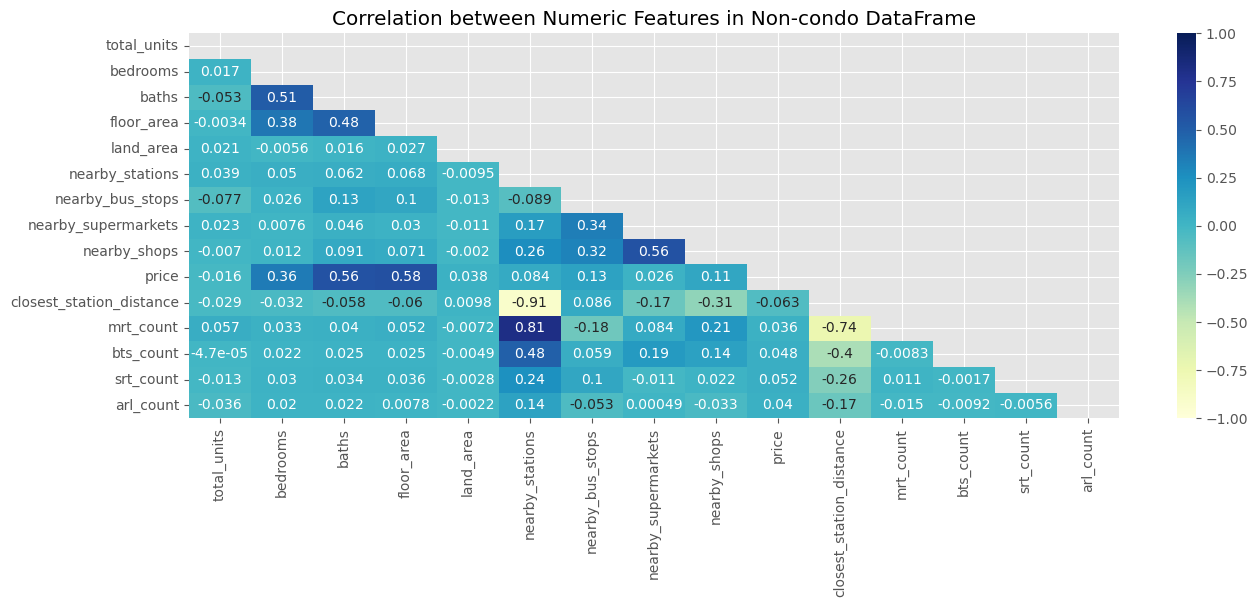

In [51]:
plt.figure(figsize = (15, 5))

corr = pd.DataFrame(train_df_non_condo.corr(numeric_only=True))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='YlGnBu', vmin=-1, vmax=1, annot=True, mask=mask);
plt.title("Correlation between Numeric Features in Non-condo DataFrame");

In [52]:
train_df_non_condo = pd.get_dummies(data=train_df_non_condo, columns = ['closest_station_name','district','property_type'], drop_first = True)
train_df_non_condo.head()

,province,subdistrict,total_units,bedrooms,baths,floor_area,land_area,nearby_stations,nearby_bus_stops,nearby_supermarkets,...,district_Saphan Sung,district_Suan Luang,district_Taling Chan,district_Thawi Watthana,district_Thon Buri,district_Thung Khru,district_Wang Thonglang,district_Watthana,district_Yan Nawa,property_type_Townhouse
3,Nonthaburi,Bang Khun Kong,310.0,3.0,3.0,170,248.0,0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Nonthaburi,Bang Phai,196.5,3.0,2.0,120,72.0,1,0.0,6.0,...,0,0,0,0,0,0,0,0,0,1
7,Bangkok,Sai Mai,294.0,2.0,2.0,105,72.0,0,0.0,6.0,...,0,0,0,0,0,0,0,0,0,1
11,Samut Prakan,Thepharak,318.0,3.0,3.0,108,132.0,0,0.0,13.0,...,0,0,0,0,0,0,0,0,0,1
12,Bangkok,Dok Mai,231.0,4.0,2.0,117,76.0,0,3.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [53]:
from collections import Counter 

facility_counter = Counter()
for i in train_df_non_condo.facilities:
    facility_counter.update(i)

facility_counter.most_common()[:30]

[('24 hours security', 2601),
 ('CCTV', 1650),
 ('Swimming pool', 1461),
 ('Community Garden', 1342),
 ('Clubhouse', 1174),
 ('Covered car park', 1098),
 ('Fitness corner', 1015),
 ('Playground', 802),
 ('Car Park', 414),
 ("Children's Playground", 223),
 ('Wading pool', 155),
 ('Mini-Mart', 141),
 ('Club', 139),
 ('Jogging track', 132),
 ('Sauna', 114),
 ('Adult Fitness Stations', 80),
 ('Open car park', 79),
 ('Basketball court', 78),
 ('Steam bath', 66),
 ('Pavillion', 56),
 ('Multi-Storey Car Park', 48),
 ('Jacuzzi', 45),
 ('Tennis courts', 41),
 ('Community Plaza', 36),
 ('Utilities Center', 35),
 ('Launderette', 30),
 ('Meeting room', 25),
 ('Function room', 17),
 ('Gymnasium room', 16),
 ('Main entrance', 15)]

In [54]:
for col in facility_counter.keys():
    train_df_non_condo[col] = train_df_non_condo['facilities'].apply(lambda x: 1 if col in x else 0)

In [55]:
train_df_non_condo = train_df_non_condo.drop(['subdistrict','province','facilities'], axis=1)

In [56]:

train_df_non_condo._get_numeric_data().columns

features = [col for col in train_df_non_condo._get_numeric_data().columns if col != 'price']

X = train_df_non_condo[features]
y = train_df_non_condo['price']
X_train_non_condo, X_test_non_condo, y_train_non_condo, y_test_non_condo = train_test_split(X,y,random_state=42)

ss = StandardScaler()
ss.fit(X_train_non_condo)
X_train_non_condo_scaled = ss.transform(X_train_non_condo)
X_test_non_condo_scaled = ss.transform(X_test_non_condo)


In [57]:
#Defining Model

lasso = LassoCV(n_alphas=100)

#Training Model

lasso.fit(X_train_non_condo_scaled,y_train_non_condo)

lasso_scores = cross_val_score(lasso,X_train_non_condo_scaled,y_train_non_condo, cv=5)
lasso_scores.mean()

0.6584399721677195

In [58]:
lasso.alpha_

16776.084405255595

In [59]:
# R-square on Training set
lasso.score(X_train_non_condo_scaled,y_train_non_condo)

0.695495349334351

In [60]:
#R-square on test set
lasso.score(X_test_non_condo_scaled,y_test_non_condo)

0.6456142875760982

In [61]:
#Training RMSE

pred_train = lasso.predict(X_train_non_condo_scaled)

np.sqrt(mean_squared_error(y_train_non_condo,pred_train))

1178004.216216811

In [62]:
#Test RMSE

pred = lasso.predict(X_test_non_condo_scaled)

np.sqrt(mean_squared_error(y_test_non_condo,pred))

1259870.6644209684

In [63]:
# coef result
lasso.coef_

array([-2.26736830e+04,  0.00000000e+00,  6.36543899e+05,  4.66718499e+05,
        3.09448002e+04,  0.00000000e+00,  6.72993019e+04, -3.17338519e+03,
        3.41749775e+04, -0.00000000e+00,  2.62937193e+04, -0.00000000e+00,
        6.62706926e+03,  0.00000000e+00, -0.00000000e+00, -3.16115617e+04,
        0.00000000e+00,  0.00000000e+00,  2.81723784e+04,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  2.15176885e+04,  0.00000000e+00,
        5.43056948e+03, -0.00000000e+00, -0.00000000e+00,  2.46004884e+04,
       -2.65093448e+04,  0.00000000e+00,  5.78723516e+03,  7.59948063e+03,
        2.04150020e+04, -0.00000000e+00,  0.00000000e+00,  2.99566861e+04,
       -0.00000000e+00, -1.00653169e+04,  0.00000000e+00,  3.64518743e+04,
       -0.00000000e+00,  0.00000000e+00,  2.86281401e+04, -3.16303500e+04,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        4.08204666e+04,  1.59838421e+04, -0.00000000e+00,  0.00000000e+00,
        3.86408886e+04, -

In [64]:
#Top5 Coef
pd.DataFrame(pd.Series(lasso.coef_,index=features).sort_values(ascending=False), columns = ['Coefficient(LassoCV)']).head(5)

,Coefficient(LassoCV)
baths,636543.899066
floor_area,466718.499169
Fitness corner,162054.378310
district_Lat Phrao,143584.406956
district_Suan Luang,136479.639207


In [65]:
#Bottom5 Coef
pd.DataFrame(pd.Series(lasso.coef_,index=features).sort_values(ascending=False), columns = ['Coefficient(LassoCV)']).tail(5)

,Coefficient(LassoCV)
district_Bang Yai,-89613.809537
district_Sai Noi,-111354.173896
district_Phra Samut Jadee,-131337.263063
district_Bang Bua Thong,-229949.944098
property_type_Townhouse,-802908.524608
